# Imports

https://github.com/facebookresearch/faiss/wiki/Getting-started

**We assume row-major storage, ie. the j'th component of vector number i is stored in row i, column j of the matrix. Faiss uses only 32-bit floating point matrices.**

In [57]:
import numpy as np
import faiss

In [58]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Setup

In [59]:
pg = 0

In [60]:
xb = np.load('pred/feats_train_pg'+str(pg)+'.npy')
yb = np.load('pred/targs_cl_train_pg'+str(pg)+'.npy')
xq = np.load('pred/feats_valid_pg'+str(pg)+'.npy')
yq = np.load('pred/targs_cl_valid_pg'+str(pg)+'.npy')

In [61]:
xb.shape # nb-by-d

(43032, 512)

In [62]:
xq.shape # nq-by-d (query vectors)

(3866, 512)

In [63]:
yb.shape, yq.shape

((43032,), (3866,))

In [64]:
## setup
d = xb.shape[1] # 512
nlist = int(4*np.sqrt(xb.shape[0])) # https://github.com/facebookresearch/faiss/issues/112
d, nlist

(512, 829)

In [65]:
quantizer = faiss.IndexFlatIP(d)
index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_INNER_PRODUCT)

https://github.com/facebookresearch/faiss/wiki/FAQ#how-can-i-index-vectors-for-cosine-distance

In [66]:
xb.max()

259.20917

In [67]:
faiss.normalize_L2(xb)

In [68]:
xb.max()

0.1784907

In [69]:
index.train(xb)

In [70]:
index.add_with_ids(xb, yb)

In [71]:
print(index.is_trained)
print(index.ntotal)

True
43032


## Train dataset

In [72]:
## search
k = 5 # we want to see 5 nearest neighbors
D_train, I_train = index.search(xb, k) # sanity check
print(I_train[:5])
print(yb[:5].reshape((5,1)))
print(D_train[:5])

[[601 601 601 601 601]
 [495 495 495 495 495]
 [473 473 473 473 473]
 [887 887 887 887 887]
 [902 902 902 902 902]]
[[601]
 [495]
 [473]
 [887]
 [902]]
[[1.         0.9835036  0.9827794  0.98229086 0.980168  ]
 [1.         0.9931759  0.99197114 0.99090976 0.99063003]
 [1.0000001  0.9991114  0.99902153 0.99899423 0.9987855 ]
 [1.0000002  0.9995822  0.9993615  0.99899846 0.9986292 ]
 [0.9999999  0.99868685 0.9977244  0.9971129  0.99709225]]


In [73]:
yb.max(), I_train.max()

(1098, 1098)

### Train accuracy

In [74]:
I_train[:,0].shape, yb.shape

((43032,), (43032,))

In [75]:
# Accuracy
np.equal(I_train[:,0], yb).sum()/len(yb)

1.0

In [76]:
I_train[:10,0], yb[:10]

(array([ 601,  495,  473,  887,  902, 1017,  457,  867,  149, 1044]),
 array([ 601,  495,  473,  887,  902, 1017,  457,  867,  149, 1044]))

In [77]:
I_train[-10:,0], yb[-10:]

(array([ 100,  733,  245,   41,  723,  837,  874, 1043,  781,  580]),
 array([ 100,  733,  245,   41,  723,  837,  874, 1043,  781,  580]))

### Train confusion matrix

In [78]:
#cm = confusion_matrix(I_train[:,0], yb)

In [79]:
#fig, ax = plt.subplots(figsize=(15,15))
#ax.matshow(cm, cmap='hot')

## Valid dataset

In [80]:
xq.max()

177.35521

In [81]:
faiss.normalize_L2(xq)

In [82]:
xq.max()

0.18986821

In [83]:
D_valid, I_valid = index.search(xq, k) # actual search

In [84]:
xq.shape, yq.shape

((3866, 512), (3866,))

In [85]:
I_valid.shape, D_valid.shape

((3866, 5), (3866, 5))

In [86]:
print(I_valid[:5]) # neighbors of the 5 first queries
print(yq[:5].reshape((5,1)))
print(D_valid[:5])

[[ 423  423  423  423  423]
 [ 844  844  844  844  844]
 [ 315  315  315  315  315]
 [ 383  383  383  383  383]
 [1017 1017 1017 1017 1017]]
[[ 423]
 [ 844]
 [ 315]
 [ 383]
 [1017]]
[[0.9651239  0.96456116 0.9577879  0.9541413  0.95166576]
 [0.82083213 0.8151076  0.81503195 0.80944073 0.80909705]
 [0.996237   0.9946344  0.99435997 0.99388695 0.9937593 ]
 [0.69589555 0.66754836 0.657987   0.6503139  0.5999608 ]
 [0.9958776  0.99585927 0.9956485  0.99557704 0.9955683 ]]


In [87]:
print(I_valid[-5:]) # neighbors of the 5 last queries
print(yq[-5:].reshape((5,1)))
print(D_valid[-5:])

[[428 428 428 428 428]
 [269 269 269 269 269]
 [383 383 383 383 383]
 [182 182 182 182 182]
 [334 334 334 334 334]]
[[ 428]
 [1063]
 [ 383]
 [ 182]
 [ 334]]
[[0.9904431  0.9897543  0.98925257 0.98905104 0.9888605 ]
 [0.6965127  0.6685593  0.65593624 0.64689094 0.64391494]
 [0.78546035 0.7519771  0.7241651  0.6944892  0.6887586 ]
 [0.8264433  0.8249481  0.7862728  0.76829356 0.7574538 ]
 [0.99058104 0.98995066 0.9885763  0.9882014  0.9879103 ]]


In [88]:
np.save('pred/preds_valid_pg'+str(pg)+'.npy', I_valid)

### Valid accuracy

In [89]:
I_valid[:,0]

array([423, 844, 315, ..., 383, 182, 334])

In [90]:
yq

array([423, 844, 315, ..., 383, 182, 334])

In [91]:
# Correct elements
np.equal(I_valid[:,0], yq).sum()

2474

In [92]:
# Accuracy
np.equal(I_valid[:,0], yq).sum()/len(yq)

0.6399379203310915

In [93]:
valid_correct = np.equal(I_valid[:,0], yq)

In [94]:
valid_correct

array([ True,  True,  True, ...,  True,  True,  True])

In [95]:
np.save('pred/preds_valid_correct_pg'+str(pg)+'.npy', valid_correct)

### Valid confusion matrix

In [96]:
cm = confusion_matrix(I_valid[:,0], yq)

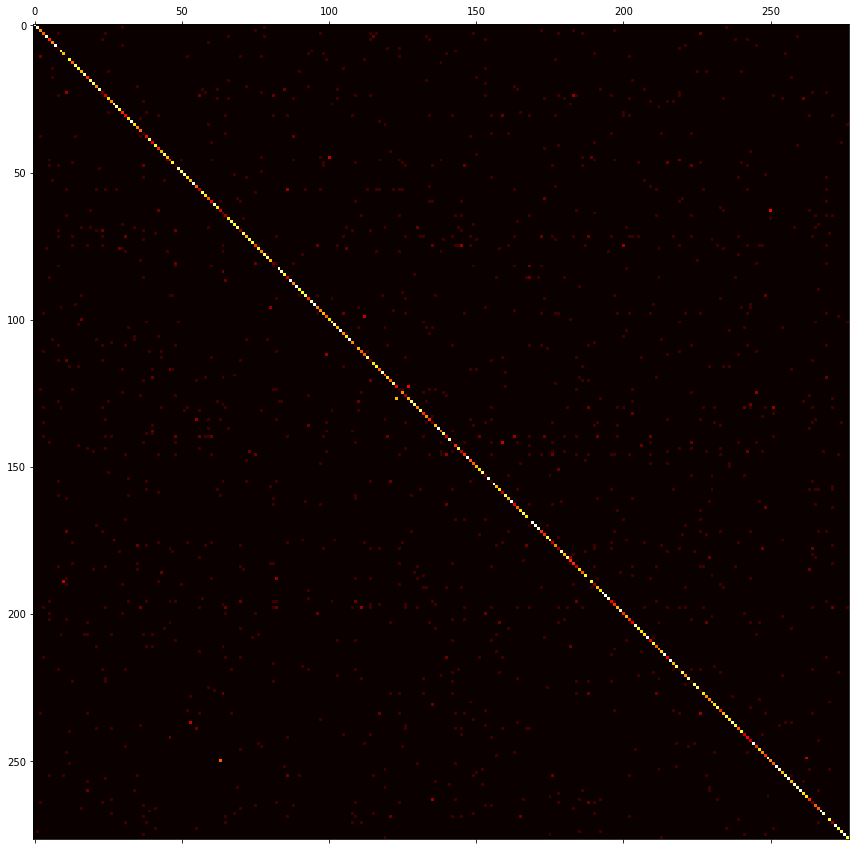

In [97]:
fig, ax = plt.subplots(figsize=(15,15))
ax.matshow(cm, cmap='hot')

#### Work in progress

In [41]:
cm.shape

(1108, 1108)

In [42]:
np.eye(1108, dtype=bool)

array([[ True, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False,  True]])

In [43]:
cm[np.eye(1108, dtype=bool)].sum()

9690

In [44]:
cm[~np.eye(1108, dtype=bool)].sum()

5786

In [45]:
cm[np.eye(1108, dtype=bool)].sum()/(cm[~np.eye(1108, dtype=bool)].sum() + cm[np.eye(1108, dtype=bool)].sum())

0.6261307831481003

In [46]:
~np.eye(1108, dtype=bool)

array([[False,  True,  True, ...,  True,  True,  True],
       [ True, False,  True, ...,  True,  True,  True],
       [ True,  True, False, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ..., False,  True,  True],
       [ True,  True,  True, ...,  True, False,  True],
       [ True,  True,  True, ...,  True,  True, False]])

In [47]:
cm[~np.eye(1108, dtype=bool)]

array([0, 0, 0, ..., 0, 0, 0])

In [48]:
-(np.eye(1108)-1)

array([[-0.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1., -0.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1., -0., ...,  1.,  1.,  1.],
       ...,
       [ 1.,  1.,  1., ..., -0.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1., -0.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1., -0.]])

In [49]:
cm * -(np.eye(1108)-1)

array([[-0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., -0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., -0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., -0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0., -0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0., -0.]])

In [50]:
cm_wodia = (cm * -(np.eye(1108)-1))

In [51]:
cm_wodia.shape

(1108, 1108)

In [52]:
cm_wodia.sum(axis=0)

array([3., 5., 4., ..., 7., 6., 5.])

In [53]:
cm_wodia.sum(axis=1)

array([ 9.,  6.,  1., ...,  3., 10.,  4.])

In [73]:
# from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
#def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(I_test[:,0], yq, classes=np.unique(yq),
                      title='Confusion matrix, without normalization')
plt.show()

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(I_test[:,0], yq, #classes=np.unique(yq), normalize=True,
                      title='Normalized confusion matrix')
plt.show()

## Test dataset

In [98]:
xq_test = np.load('pred/feats_test_pg'+str(pg)+'.npy')

In [99]:
xq_test.max()

150.27078

In [100]:
faiss.normalize_L2(xq_test)

In [101]:
xq_test.max()

0.18782754

In [102]:
D_test, I_test = index.search(xq_test, k) # actual search

In [103]:
xq_test.shape, I_test.shape, D_test.shape

((9942, 512), (9942, 5), (9942, 5))

In [104]:
print(I_test[:5]) # neighbors of the 5 first queries
print(D_test[:5])

[[1098 1098 1098 1098 1098]
 [ 327  327  327  327  327]
 [ 789   -1   -1   -1   -1]
 [ 169  169  169  169  169]
 [ 189  189  189  189  189]]
[[ 9.4882298e-01  9.4388199e-01  9.3033653e-01  9.2862606e-01
   9.2855859e-01]
 [ 7.5373971e-01  7.5351256e-01  7.5155526e-01  7.4962169e-01
   7.4866110e-01]
 [ 5.1525921e-01 -3.4028235e+38 -3.4028235e+38 -3.4028235e+38
  -3.4028235e+38]
 [ 9.5086586e-01  9.4241190e-01  9.3651819e-01  9.3523097e-01
   9.3505520e-01]
 [ 9.3431777e-01  9.2937136e-01  9.2853355e-01  9.2434609e-01
   9.2334962e-01]]


In [105]:
print(I_test[-5:]) # neighbors of the 5 last queries
print(D_test[-5:])

[[721 721 721 721 721]
 [232 232 232 232 232]
 [951 951 951 951 951]
 [100 779  11 779 779]
 [813 813 813 813 813]]
[[0.6419461  0.6340849  0.6334372  0.6320419  0.6312835 ]
 [0.4545082  0.43888897 0.4335062  0.4331058  0.43204352]
 [0.5828091  0.49525142 0.49361253 0.47268882 0.4705543 ]
 [0.6579174  0.6412853  0.62168366 0.57381386 0.4561351 ]
 [0.7793168  0.7635528  0.74149626 0.73847646 0.736199  ]]


In [106]:
I_test[2]

array([789,  -1,  -1,  -1,  -1])

In [107]:
np.unique(I_test[2], return_counts=True)

(array([ -1, 789]), array([4, 1]))

In [108]:
np.save('pred/preds_test_pg'+str(pg)+'_full.npy', I_test)
np.save('pred/dist_test_pg'+str(pg)+'_full.npy', D_test)

In [109]:
preds_test = I_test[:,0]
dist_test = D_test[:,0]

In [110]:
np.save('pred/preds_test_pg'+str(pg)+'.npy', preds_test)
np.save('pred/dist_test_pg'+str(pg)+'.npy', dist_test)

#### Get mode or most similiar if mode is 1

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mode.html#scipy.stats.mode

**This seems to not increase the accuracy !!!**

In [27]:
from scipy import stats

In [28]:
# get mode and mode count
I_test_mode = stats.mode(I_test, axis=1)

In [29]:
I_test.shape, I_test_mode[0].shape

((39794, 5), (39794, 1))

In [30]:
I_test[:5]

array([[ 591,  591,  587,  591,  855],
       [ 736,  770,  387,  728,  933],
       [ 179,  576,  191,  451, 1076],
       [ 908,  908,  609,  256,  892],
       [ 775,  445,  970,  387,  307]])

In [31]:
I_test_mode[0][:5]

array([[591],
       [387],
       [179],
       [908],
       [307]])

In [32]:
I_test_mode[1][:5]

array([[3],
       [1],
       [1],
       [2],
       [1]])

In [33]:
I_test_mode[1] == 1

array([[False],
       [ True],
       [ True],
       ...,
       [False],
       [False],
       [False]])

In [34]:
mode_mask = (~(I_test_mode[1] == 1)).astype('float')
similar_mask = (I_test_mode[1] == 1).astype('float')

In [35]:
mode_mask[:5]

array([[1.],
       [0.],
       [0.],
       [1.],
       [0.]])

In [36]:
similar_mask[:5]

array([[0.],
       [1.],
       [1.],
       [0.],
       [1.]])

In [37]:
I_test[:,0]

array([ 591,  736,  179, ...,  108, 1074,  316])

In [38]:
similar_mask.shape

(39794, 1)

In [39]:
I_test[:,0].shape, similar_mask.shape

((39794,), (39794, 1))

In [40]:
I_test[:,0].reshape((-1,1)).shape

(39794, 1)

In [41]:
I_most_similar = np.multiply(I_test[:,0].reshape((-1,1)),similar_mask)

In [42]:
I_most_similar[:5]

array([[  0.],
       [736.],
       [179.],
       [  0.],
       [775.]])

In [43]:
I_higher_mode = np.multiply(I_test_mode[0],mode_mask)

In [44]:
I_higher_mode[:5]

array([[591.],
       [  0.],
       [  0.],
       [908.],
       [  0.]])

In [45]:
preds_similar_mode = I_most_similar + I_higher_mode

In [46]:
preds_similar_mode[:5]

array([[591.],
       [736.],
       [179.],
       [908.],
       [775.]])

In [51]:
np.save('pred/preds_test_similar_mask', similar_mask)
np.save('pred/preds_test_mode_mask', mode_mask)
np.save('pred/preds_test_similar_mode', preds_similar_mode)